In [95]:
from imutils.perspective import four_point_transform
from imutils import contours
import numpy as np
import imutils
import cv2
from matplotlib import pyplot as plt

from IPython.core.pylabtools import figsize
figsize(10, 10)

In [96]:
ANSWER_KEY = {0: 1, 1: 4, 2: 0, 3: 3, 4: 1}

In [97]:
imagePath = '../images/optic.png'

image = cv2.imread(imagePath)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 75, 200)

In [98]:
print "Height:\t\t%i pixels\nWidth:\t\t%i pixels\nChannels:\t%i" % image.shape

Height:		700 pixels
Width:		525 pixels
Channels:	3


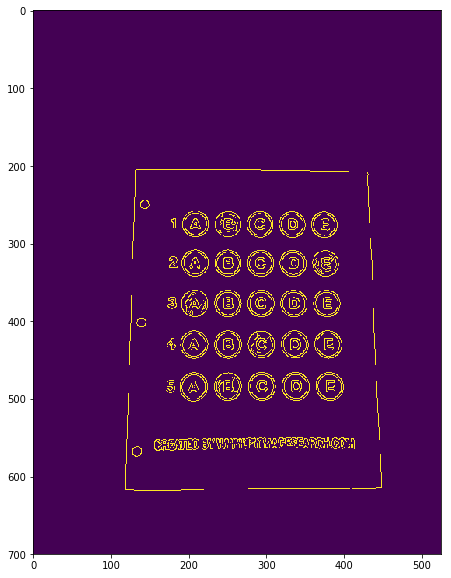

In [99]:
plt.imshow(edged)
plt.show()

In [100]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]
docCnt = None
 
# ensure that at least one contour was found
if len(cnts) > 0:
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        
        if len(approx) == 4:
            docCnt = approx
            break

In [101]:
paper = four_point_transform(image, docCnt.reshape(4, 2))
warped = four_point_transform(gray, docCnt.reshape(4, 2))

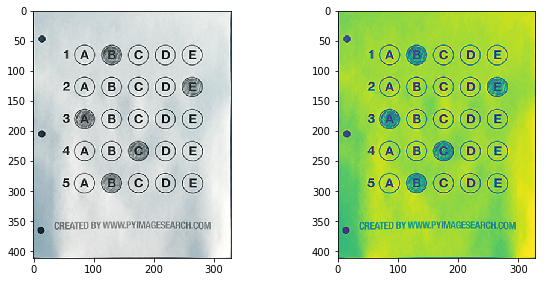

In [102]:
plt.figure(1)
plt.subplot(221)
plt.imshow(paper)

plt.subplot(222)
plt.imshow(warped)
plt.show()

In [103]:
thresh = cv2.threshold(warped, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

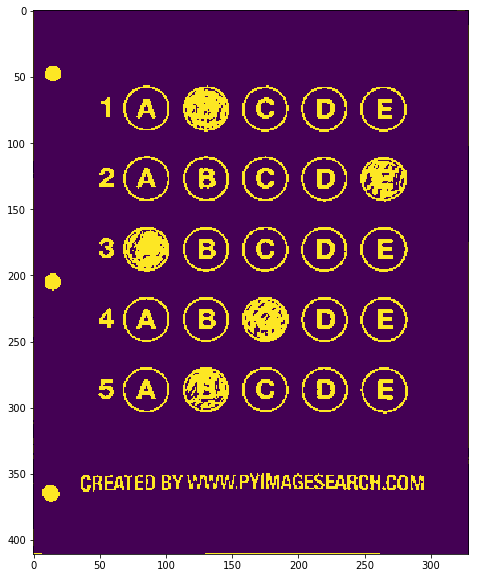

In [104]:
plt.imshow(thresh)
plt.show()

In [105]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]
questionCnts = []
 
# loop over the contours
for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)
    
    if w >= 20 and h >= 20 and ar >= 0.9 and ar <= 1.1:
        questionCnts.append(c)

In [106]:
questionCnts = contours.sort_contours(questionCnts, method="top-to-bottom")[0]
correct = 0
 
# each question has 5 possible answers, to loop over the
# question in batches of 5
for (q, i) in enumerate(np.arange(0, len(questionCnts), 5)):
    
    cnts = contours.sort_contours(questionCnts[i:i + 5])[0]
    bubbled = None
    

    for (j, c) in enumerate(cnts):
        mask = np.zeros(thresh.shape, dtype="uint8")
        cv2.drawContours(mask, [c], -1, 255, -1)
        
        mask = cv2.bitwise_and(thresh, thresh, mask=mask)
        total = cv2.countNonZero(mask)
                
        if bubbled is None or total > bubbled[0]:
            bubbled = (total, j)
            
    color = (0, 0, 255)
    k = ANSWER_KEY[q]
 
    # check to see if the bubbled answer is correct
    if k == bubbled[1]:
        color = (0, 255, 0)
        correct += 1
 

    cv2.drawContours(paper, [cnts[k]], -1, color, 3)

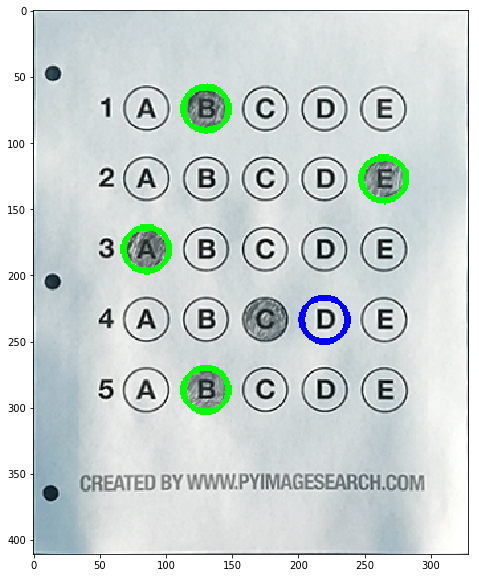

In [107]:
plt.imshow(paper)
plt.show()

[INFO] score: 80.00%


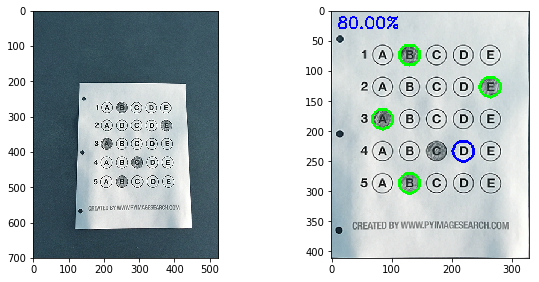

In [109]:
score = (correct / 5.0) * 100

print("[INFO] score: {:.2f}%".format(score))
cv2.putText(paper, "{:.2f}%".format(score), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

plt.figure(1)
plt.subplot(221)
plt.imshow(image)

plt.subplot(222)
plt.imshow(paper)
plt.show()

plt.show()
